In [1]:
import pandas as pd
import numpy as np
import itertools as it
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import os
import glasbey
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
hyps = {"kmeans": {"n_clusters": list(range(1, 16)) + [20, 30, 40, 50, 60], "n_init": ["auto"]},
        "ward": {"n_clusters": range(1, 31), "distance_threshold": [None], "linkage": ["ward"]},
        # "dbscan": {"eps": np.linspace(0.1, 1.0, 30), "min_samples": range(2, 100, 10)},
        "dbscan": {"eps": np.linspace(0.07, 0.1, 30), "min_samples": range(2, 20, 10)},
        "hdbscan": {"min_cluster_size": [2, 10, 20, 30, 40, 50, 60, 100]},
        "optics": {"min_samples": range(1, 16), "max_eps": [np.inf]}}

In [3]:
# 3d plot
def coupled_label_plot(df, umap_plot=True):
    mymap = Basemap(llcrnrlon=df["LONGITUDE"].min(), llcrnrlat=df["LATITUDE"].min(), 
                    urcrnrlon=df["LONGITUDE"].max(), urcrnrlat=df["LATITUDE"].max(), fix_aspect=False)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df["LONGITUDE"], df["LATITUDE"], df["LEV_M"], c=df["color"], s=0.5, alpha=1, zorder=4)  # df["predictions"]
    ax.add_collection3d(mymap.drawcoastlines(linewidth=0.5))
    ax.set_box_aspect((np.ptp(df["LONGITUDE"]), np.ptp(df["LATITUDE"]), np.ptp(df["LEV_M"])/50))  # aspect ratio is 1:1:1 in data space
    plt.gca().invert_zaxis()
    plt.show()

    if umap_plot:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df["e0"], df["e1"], df["e2"], c=df["color"], alpha=0.8, zorder=4, s=1)  # , s=s, alpha=1, zorder=4)
        plt.show(block=True)

In [6]:
# @dask.delayed
def func(df, hyp_combo, algorithm, iteration, prefix=None):
    print(hyp_combo)
    filename = f"out2/scores_{algorithm}_{prefix}_i{iteration}_{'_'.join([str(k)+str(v) for k, v in hyp_combo.items()])}.csv"
    scores = pd.DataFrame(columns=["iteration", "silhouette", "davies_bouldin", "calinski"] + list(hyp_combo.keys()))

    if not os.path.isfile(filename):
        if algorithm == "kmeans":
            kmeans = KMeans(**hyp_combo).fit(df)
            y_pred = kmeans.predict(df)
            # plot_3d(df_in, kmeans_labels)
        elif algorithm == "ward":
            model = AgglomerativeClustering(**hyp_combo).fit(df)
            y_pred = model.labels_
        elif algorithm == "dbscan":
            model = DBSCAN(**hyp_combo).fit(df)
            y_pred = model.labels_
        elif algorithm == "optics":
            model = OPTICS(**hyp_combo).fit(df)
            y_pred = model.labels_
        elif algorithm == "hdbscan": 
            model = HDBSCAN(**hyp_combo).fit(df)
            y_pred = model.labels_
        else:
            print("Clustering algorithm not implemented")
    
        nclusters = len(np.unique(y_pred))
        if nclusters > 1:
            sil = silhouette_score(df, y_pred)
            db = davies_bouldin_score(df, y_pred)
            cal = calinski_harabasz_score(df, y_pred)
        else:
            sil = np.nan
            db = np.nan
            cal = np.nan
    
        scores = pd.concat([scores, pd.DataFrame({"nclusters": nclusters, "iteration": [iteration], "silhouette": [sil], "davies_bouldin": [db], "calinski": [cal]})])
        scores.reset_index(inplace=True, drop=True)
        scores = scores.combine_first(pd.DataFrame.from_dict([hyp_combo]).set_index(pd.Series(len(scores)-1)))
    
        scores.to_csv(filename, index=False)

    return scores

In [7]:
# @dask.delayed
def compute_scores(df, algorithm="kmeans", iterations=10, prefix=None):
    hyp_dict = hyps[algorithm]
    hyp_combinations = list(it.product(*hyp_dict.values()))

    res = []
    
    for i in range(iterations):
        print(i)
        for h in hyp_combinations:
            print(h)
            hyp_combo = dict((b, a) for a, b in zip(h, hyp_dict.keys()))
            res.append(func(df=df, hyp_combo=hyp_combo, algorithm=algorithm, iteration=i, prefix=prefix))
            
    return res

In [8]:
def plot_heatmap(df, x="min_samples", y="eps", color="nclusters", title="Sweep of DBSAN"):
    idx = df[y].unique()
    cols = df[x].unique()
    field = pd.DataFrame(df[color].to_numpy().reshape(len(idx), len(cols)), index=idx, columns=cols)
    sns.heatmap(data=field, cbar_kws={'label': color}, annot=True, fmt='g')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

In [9]:
def plot_coefficients(scores, x="n_clusters", algorithm="kmeans", output_path="output/clustering/", suffix=None, save=True):
    plot_score(scores, x, "silhouette")  # KMeans: k=10 (close to 1 = best)
    if save:
        plt.savefig(f"{output_path}{algorithm}/silhouette_{algorithm}_{x}{suffix}.png")
    plt.show()

    plot_score(scores, x, "davies_bouldin")  # KMeans: k=10 (closest to minimum (zero)
    if save:
        plt.savefig(f"{output_path}{algorithm}/davies_bouldin_{algorithm}_{x}{suffix}.png")
    plt.show()

    plot_score(scores, x, "calinski")  # KMeans: k= (max is best)
    if save:
        plt.savefig(f"{output_path}{algorithm}/calinski_harabasz_{algorithm}_{x}{suffix}.png")
    plt.show()

In [10]:
def plot_score(df, x, y):
    xmap = {"n_clusters": "Number of clusters", "eps": "Epsilon", "min_samples": "Minimum number of samples"}
    df_mean = df.dropna()[[x, y]].groupby(x).mean()
    if y == "silhouette":
        t = "Silhouette Score"
        optimal_x = df_mean.idxmax().values[0]
    elif y == "davies_bouldin":
        t = "Davies Bouldin Score"
        optimal_x = df_mean.idxmin().values[0]
    elif y == "calinski":
        t = "Calinski Harabasz Score"
        optimal_x = df_mean.idxmax().values[0]

    # plt.plot(df[x], df[y])
    plt.figure()
    sns.lineplot(df, x=x, y=y)
    plt.ylabel(t)
    plt.xlabel(xmap[x])
    plt.axvline(optimal_x, color="orange")
    plt.tight_layout()

In [11]:
# load data
df_in = pd.read_csv("../ocean_clusters_over_time/data/df_knn_3x20.csv")
df = df_in[['P_SILICATE', 'P_OXYGEN', 'P_PHOSPHATE', 'P_NITRATE', 'P_SALINITY', 'P_TEMPERATURE']]

In [12]:
# scale
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [13]:
# # find a good embedding
# for dist, neighbors in list(it.product([0.0, 0.1, 0.2, 0.5, 1.0], [5, 10, 15, 20, 50])):
#     # embed
#     embedding = umap.UMAP(min_dist=dist, n_components=3, n_neighbors=neighbors).fit_transform(df_scaled)
    
#     fig = plt.figure(figsize=(7, 6))
#     ax = fig.add_subplot(projection='3d')
#     ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
#     plt.xlabel("Axis 0")
#     plt.ylabel("Axis 1")
#     ax.set_zlabel("Axis 2")
#     plt.title(f"min_dist={dist}, n_neighbors={neighbors}")
#     plt.tight_layout()
#     plt.savefig(f"output/umap_mindist{dist}_nneighbors{neighbors}.png")
#     plt.show()

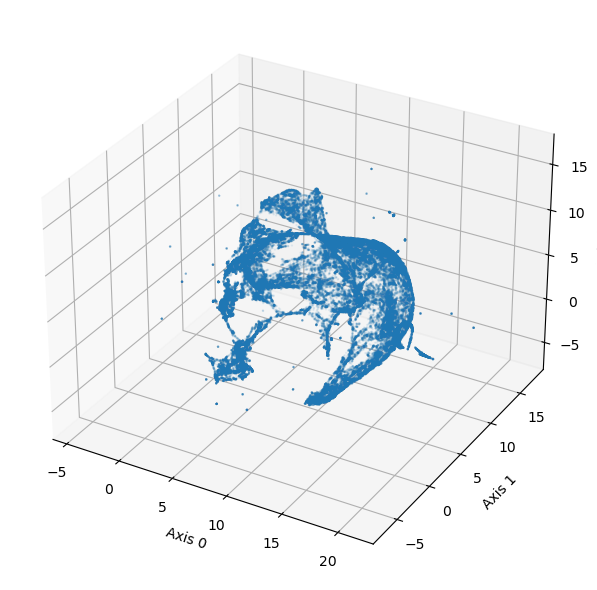

In [14]:
# embed data
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=10).fit_transform(df_scaled)

# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
plt.savefig("output/umap_space.png")
plt.show()

# DBSCAN tuning

In [ ]:
os.getcwd()

In [ ]:
from dask.distributed import Client

client = Client(n_workers=8)
client

In [ ]:
dbscan_scores = compute_scores(df=embedding, algorithm="dbscan", iterations=1)

In [ ]:
res = dask.compute(*dbscan_scores)

In [ ]:
# import glob
# res = []
# for f in glob.glob("out2/scores_dbscan_i*_eps*_min_samples*.csv"):
#     a = pd.read_csv(f)
#     res.append(a)

In [ ]:
res = pd.concat(res)

In [ ]:
# res.to_csv("", index=False)

In [ ]:
# plot_heatmap(res.sort_values(["eps", "min_samples"]), x="min_samples", y="eps", color="nclusters", title="Sweep of DBSCAN (on original data)")
# plt.show()

In [ ]:
# plot scores
res["eps"] = res["eps"].astype(float)
res["iteration"] = res["iteration"].astype(float)
res["min_samples"] = res["min_samples"].astype(float)
res_i = res.groupby(["eps", "min_samples"]).mean().drop("iteration", axis=1).reset_index()

plot_heatmap(res_i, x="min_samples", y="eps", color="nclusters", title="Sweep of DBSCAN (on original data)")
plt.show()

plot_coefficients(res, x="eps", algorithm="dbscan", save=False)
plot_coefficients(res, x="min_samples", algorithm="dbscan", save=False)

# #for e, m in [(0.110345, 2), (0.1, 3), (0.5, 5), (0.12413793103448277, 6)]:
# dlabels = df["label"] # compute_clusters(df_scaled, df_in, algorithm="dbscan", hyps={"eps": e, "min_samples": m}, spec="original_data")
# print(f"Number of clusters: {len(np.unique(dlabels))}")
# coupled_label_plot(df) # , dlabels, embedding)

In [ ]:
hyps["dbscan"]

## Compute optimal clustering

In [ ]:
model = DBSCAN(eps= 0.085, min_samples=10)
model.fit(embedding)

In [ ]:
df_in["label"] = model.labels_
df_in["LONGITUDE"] = np.arcsin(df_in["LONGITUDE0"])/(2*np.pi)*360*(-1)

df_in["e0"] = embedding[:, 0]
df_in["e1"] = embedding[:, 1]
df_in["e2"] = embedding[:, 2]

In [ ]:
unique_labels = np.sort(np.unique(df_in["label"]))
colors = glasbey.create_palette(palette_size=len(unique_labels))
color_map = {label: color for label, color in zip(unique_labels, colors)}
df_in["color"] = df_in["label"].map(lambda x: color_map[x])
df_in.loc[df_in["label"] == -1, "color"] = "#000000"  # color noise in black
df_dropped = df_in[df_in["label"] != -1]

mymap = Basemap(llcrnrlon=df_in["LONGITUDE"].min(), llcrnrlat=df_in["LATITUDE"].min(), 
                urcrnrlon=df_in["LONGITUDE"].max(), urcrnrlat=df_in["LATITUDE"].max(), fix_aspect=False)

for year in df_in["year"].unique():
    temp = df_dropped[df_dropped["year"] == year]
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(temp["LONGITUDE"], temp["LATITUDE"], temp["LEV_M"], color=temp["color"], s=2, alpha=1, marker=".")
    ax.add_collection3d(mymap.drawcoastlines(linewidth=0.5))
    ax.set_box_aspect((np.ptp(temp["LONGITUDE"]), np.ptp(temp["LATITUDE"]),
                       np.ptp(temp["LEV_M"]) / 50))  # aspect ratio is 1:1:1 in data space
    plt.gca().invert_zaxis()
    plt.savefig(f"dbscan_{year}.png")
    plt.show()
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(temp["e0"], temp["e1"], temp["e2"], c=temp["color"], alpha=0.8, s=1)  # , s=s, alpha=1, zorder=4)
    plt.savefig(f"dbscan_umap_{year}.png")
    plt.show()

In [ ]:
# viz per depth
plt.rcParams["figure.figsize"] = (12, 6)

for year in df_in["year"].unique():
    fig, axs = plt.subplots(nrows=3, ncols=4)
    axs = axs.flatten()
    
    for i, depth in enumerate(df_in["LEV_M"].unique()):
        temp = df_in[(df_in["LEV_M"] == depth) & (df_in["year"] == year)]
        axs[i].scatter(temp["LONGITUDE"], temp["LATITUDE"], c=temp["color"], s=0.4, marker="s")
        axs[i].title.set_text(f"{depth} m")
    fig.suptitle(year)
    plt.savefig(f"dbscan_depth_{year}.png")
    plt.show()

In [ ]:
def drop_clusters_with_few_samples(df, thresh=None, ylog=False):
    """ If thresh is None, the Kneedle algorithm will be used to determine a treshold. """
    temp = df.copy()
    
    # count number of grid cells in each cluster
    df_nums = temp.groupby("label").count()["color"].reset_index().rename(columns={"color": "count"})
    df_nums = df_nums.sort_values("count").reset_index(drop=True)
    df_nums["label"] = df_nums["label"].astype(str)

    # compute threshold to cut off clusters
    if not thresh:
        cluster_label, thresh = compute_elbow_threshold(df_nums, y_name="count", y_label="Number of samples")
    else:
        # plot number of cells per cluster
        plt.plot(df_nums["label"], df_nums["count"])
        if ylog: 
            plt.yscale("log")
        plt.ylabel("Number of samples")
        plt.xlabel("Cluster")
        plt.xticks([])
        plt.axhline(thresh, color="orange")
        plt.yticks(list(plt.yticks()[0]) + [thresh])
        plt.show()

    # set all labels to -1 (noise) where num samples is too small
    labels_to_keep = df_nums[df_nums["count"] >= thresh].label
    print("Remaining number of clusters:" + str(len(labels_to_keep)))
    temp = temp[temp["label"].astype(str).isin(labels_to_keep)]

    # plotting
    # coupled_label_plot(temp)

    return temp

In [ ]:
def compute_elbow_threshold(df_label_counts, y_name="count", y_label="Number of samples"):
    x = df_label_counts.index
    y = df_label_counts[y_name]
    kn = KneeLocator(x=x, y=y, curve='convex', direction='increasing')
    knee = kn.knee

    fig = plt.figure()
    plt.xlabel('Clusters')
    plt.ylabel(y_label)
    plt.plot(x, y, "-")  # "'x-')
    plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color="orange")
    plt.hlines(df_label_counts.iloc[knee][y_name], plt.xlim()[0], plt.xlim()[1], linestyles='dashed', color="orange")
    # plt.xticks([knee], labels=[df_label_counts.iloc[knee]["labels"]])
    plt.xticks([knee])
    plt.yticks(list(plt.yticks()[0]) + [df_label_counts.iloc[knee][y_name]])
    plt.show()

    return df_label_counts.iloc[knee]["label"], df_label_counts.iloc[knee][y_name]

In [ ]:
df_dropped = drop_clusters_with_few_samples(df_in, thresh=60, ylog=True)

In [ ]:
coupled_label_plot(df_dropped[df_dropped["label"] != -1])

# Cluster with time dimension on time dataset

In [ ]:
# load data
df_in = pd.read_csv("../ocean_clusters_over_time/df_knn_3x20.csv")

In [ ]:
df_in

In [ ]:
# scale
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [ ]:
# embed data 
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=10).fit_transform(df_scaled)

# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
# plt.savefig("output/umap_space.png")
plt.show()

# The other appoach - cluster each epoch

In [ ]:
# load data
df = pd.read_csv("../ocean_clusters_over_time/df_knn_3x20.csv")

In [ ]:
# find hyperparameters
for year in df["year"].unique():
    temp = df[df["year"] == year]

    # scale
    scaler = MinMaxScaler()
    temp_scaled = scaler.fit_transform(temp)

    # embed
    embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(temp_scaled)

    # cluster
    dbscan_scores = compute_scores(df=embedding, algorithm="dbscan", iterations=1, prefix=year)

In [ ]:
import glob
res = []
year="1960.0"  # "1980.0" "2000.0"
for f in glob.glob(f"output/scores_dbscan_{year}_i*_eps*_min_samples*.csv"):
    a = pd.read_csv(f)
    a = a.drop("Unnamed: 0", axis=1)
    res.append(a)

res = pd.concat(res)

In [ ]:
res

In [ ]:
# plot scores
res["eps"] = res["eps"].astype(float)
res["iteration"] = res["iteration"].astype(float)
res["min_samples"] = res["min_samples"].astype(float)
res_i = res.groupby(["eps", "min_samples"]).mean().drop("iteration", axis=1).reset_index()

plot_heatmap(res_i, x="min_samples", y="eps", color="nclusters", title="Sweep of DBSCAN (on original data)")
plt.show()

plot_coefficients(res, x="eps", algorithm="dbscan", save=False)
plot_coefficients(res, x="min_samples", algorithm="dbscan", save=False)

#for e, m in [(0.110345, 2), (0.1, 3), (0.5, 5), (0.12413793103448277, 6)]:
#dlabels = df["label"] # compute_clusters(df_scaled, df_in, algorithm="dbscan", hyps={"eps": e, "min_samples": m}, spec="original_data")
#print(f"Number of clusters: {len(np.unique(dlabels))}")
# coupled_label_plot(df) # , dlabels, embedding)

In [17]:
import os
os.getcwd()

'/albedo/home/yvjennig/github/ocean_clusters_over_time'

# Use SOMPY

In [15]:
# determine mapsize
pca = PCA() 
pca_out =pca.fit_transform(embedding)
eigenvalue1 = pca.explained_variance_[0]
eigenvalue2 = pca.explained_variance_[1]
max_number_clusters = 500

ax1 = int(np.ceil(max_number_clusters*(eigenvalue1/(eigenvalue1+eigenvalue2))))
ax2 = int(np.ceil(max_number_clusters*(eigenvalue2/(eigenvalue1+eigenvalue2))))

print(pca.explained_variance_)

[23.78927906 22.63865166 15.99265561]


In [16]:
import sompy

In [ ]:
import time

st = time.time()

# sompy
mapsize = [ax1, ax2]  # related to proportion of eigenvectors --> take first 2 eigenvalues from PCA

som = sompy.SOMFactory.build(embedding,
                             mapsize=mapsize, 
                             mask=None, 
                             mapshape='planar', 
                             lattice='hexa', 
                             normalization=None, 
                             initialization='pca', 
                             neighborhood='gaussian', 
                             training='batch', 
                             name='sompy')

som.train(n_job=4, verbose='info', 
          train_rough_len=60,  # 100
          train_rough_radiusin=5, # (initial radius, how conctracted the map is initially)
          train_rough_radiusfin=1,
          train_finetune_len=80, # 300+ (epochs)
          train_finetune_radiusin=1.3,
          train_finetune_radiusfin=0.1,)  # verbose='debug' will print more, and verbose=None wont print anything

print(time.time() - st)

 Training...
 pca_linear_initialization took: 0.605000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.000000, trainlen: 60

 epoch: 1 ---> elapsed time:  166.965000, quantization error: 3.316564

 epoch: 2 ---> elapsed time:  185.967000, quantization error: 4.929876

 epoch: 3 ---> elapsed time:  199.720000, quantization error: 2.901507

/albedo/home/yvjennig/.conda/envs/time310/lib/python3.10/site-packages/SOMPY-1.1.1-py3.10.egg/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
 epoch: 4 ---> elapsed time:  196.815000, quantization error: nan

nan quantization error, exit train

 epoch: 5 ---> elapsed time:  225.068000, quantization error: 1.830242

 epoch: 6 ---> elapsed time:  249.532000, quantization error: 1.735969

 epoch: 7 ---> elapsed time:  252.759000, quantization error: 1.663316

 epoch: 8 ---> elapsed time:  249.724000, quantization error: 1.595105

 epoch: 9 ---> elapsed time:  257.428000, quantization error: 1.528902

 epoch: 10 --

In [ ]:
import pickle

In [ ]:
pickle.dump(som, open("som.pickle", 'wb'))

In [ ]:
if not som:
    import pickle
    loaded_model = pickle.load(open("som.pickle", 'rb'))
else:
    loaded_model = som

In [ ]:
loaded_model

In [ ]:
df_in["e0"] = embedding[:, 0]
df_in["e1"] = embedding[:, 1]
df_in["e2"] = embedding[:, 2]

In [ ]:
bmus = som.find_bmu(df[["e0", "e1", "e2"]])#, njb=1, nth=1)#, metric='euclidean')
df_in["bmu"] = bmus[0,:]

In [ ]:
df_in["bmu1"] = bmus[1,:]

In [ ]:
df_in.to_csv("sompy_over_time.csv", index=False)

In [ ]:
embedding nan?